In [3]:
import datetime
from datetime import timedelta

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
from tensorflow.contrib.timeseries.python.timeseries import estimators as tfts_estimators
from tensorflow.contrib.timeseries.python.timeseries import model as tfts_model

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Read train data

In [4]:
dtypes = {'id':'int64', 'item_nbr':'int32', 'store_nbr':'int8'}

train = pd.read_csv('../input/train.csv', usecols=[1,2,3,4], dtype=dtypes, parse_dates=['date'], 
                    skiprows=range(1, 101688780) #Skip initial dates 
)
# skiprows memory문제 때문에 

train.loc[(train.unit_sales < 0),'unit_sales'] = 0 # eliminate negatives

#unit_sales +1 하고 로그 취한 스케일
train['unit_sales'] =  train['unit_sales'].apply(pd.np.log1p) #logarithm conversion
train['dow'] = train['date'].dt.dayofweek 

# Preprocess data

In [5]:
# creating records for all items, in all markets on all dates
# for correct calculation of daily unit sales averages.
u_dates = train.date.unique()
u_stores = train.store_nbr.unique()
u_items = train.item_nbr.unique()
train.set_index(['date', 'store_nbr', 'item_nbr'], inplace=True)
train = train.reindex(
    pd.MultiIndex.from_product(
        (u_dates, u_stores, u_items),
        names=['date','store_nbr','item_nbr']
    )
)

In [6]:
train.loc[:, 'unit_sales'].fillna(0, inplace=True) # fill NaNs
train.reset_index(inplace=True) # reset index and restoring unique columns  
lastdate = train.iloc[train.shape[0]-1].date

In [7]:
train.head()

,date,store_nbr,item_nbr,unit_sales,dow
0,2017-01-01,25,99197,0.693147,6.0
1,2017-01-01,25,103665,2.079442,6.0
2,2017-01-01,25,105574,0.693147,6.0
3,2017-01-01,25,105857,1.609438,6.0
4,2017-01-01,25,106716,1.098612,6.0


In [8]:
#날짜별로 되어있는 것에 평균
tmp = train[['item_nbr','store_nbr','dow','unit_sales']]
ma_dw = tmp.groupby(['item_nbr','store_nbr','dow'])['unit_sales'].mean().to_frame('madw')
ma_dw.reset_index(inplace=True)
ma_dw.head()

,item_nbr,store_nbr,dow,madw
0,96995,1,0.0,0.895880
1,96995,1,1.0,0.693147
2,96995,1,2.0,0.693147
3,96995,1,3.0,0.794513
4,96995,1,4.0,0.943827


In [9]:
#아이템 넘버와 스토어 넘버에 따른 평균
tmp = ma_dw[['item_nbr','store_nbr','madw']]
ma_wk = tmp.groupby(['item_nbr', 'store_nbr'])['madw'].mean().to_frame('mawk')
ma_wk.reset_index(inplace=True)
ma_wk.head()

,item_nbr,store_nbr,mawk
0,96995,1,0.844024
1,96995,2,0.775311
2,96995,3,0.786271
3,96995,4,0.783251
4,96995,5,0.882478


# Moving Average - Our Basic Model

In [10]:
tmp = train[['item_nbr','store_nbr','unit_sales']]
ma_is = tmp.groupby(['item_nbr', 'store_nbr'])['unit_sales'].mean().to_frame('mais226')

In [11]:
#1일전 3일전 일주일 전 이주전 별로 평균
for i in [112,56,28,14,7,3,1]:
    tmp = train[train.date>lastdate-timedelta(int(i))]
    tmpg = tmp.groupby(['item_nbr','store_nbr'])['unit_sales'].mean().to_frame('mais'+str(i))
    ma_is = ma_is.join(tmpg, how='left')

del tmp,tmpg

In [12]:
ma_is['mais']=ma_is.median(axis=1)
ma_is.reset_index(inplace=True)

In [13]:
ma_is.head()

,item_nbr,store_nbr,mais226,mais112,mais56,mais28,mais14,mais7,mais3,mais1,mais
0,96995,1,0.094948,0.154255,0.172356,0.295202,0.334438,0.099021,0.000000,0.000000,0.126638
1,96995,2,0.115804,0.161961,0.123776,0.049511,0.000000,0.000000,0.000000,0.000000,0.024755
2,96995,3,0.160339,0.208903,0.286789,0.336299,0.375535,0.454008,0.462098,0.693147,0.355917
3,96995,4,0.046322,0.093884,0.150635,0.099021,0.099021,0.198042,0.231049,0.693147,0.124828
4,96995,5,0.068215,0.138257,0.202249,0.237278,0.099021,0.198042,0.000000,0.000000,0.118639


# Tensorflow Timesereies - ARRegressor

In [14]:
#스토어와 아이템 하나로
def data_to_npreader(store_nbr: int, item_nbr: int) -> NumpyReader:
    unit_sales = train[np.logical_and(train["store_nbr"] == store_nbr,
                                      train['item_nbr'] == item_nbr)].unit_sales

    x = np.asarray(range(len(unit_sales)))
    y = np.asarray(unit_sales)

    dataset = {
        tf.contrib.timeseries.TrainEvalFeatures.TIMES: x,
        tf.contrib.timeseries.TrainEvalFeatures.VALUES: y,
    }

    reader = NumpyReader(dataset)
    return x, y, reader

In [15]:
x, y, reader = data_to_npreader(store_nbr=1, item_nbr=105574)

train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(
        reader, batch_size=32, window_size=40)

ar = tf.contrib.timeseries.ARRegressor(
    periodicities=21, input_window_size=30, output_window_size=10,
    num_features=1,
    loss=tf.contrib.timeseries.ARModel.NORMAL_LIKELIHOOD_LOSS
)

ar.train(input_fn=train_input_fn, steps=16000)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x116489470>, '_model_dir': '/var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmp1jzqvye3', '_save_checkpoints_steps': None, '_task_type': 'worker', '_task_id': 0, '_service': None, '_is_chief': True, '_log_step_count_steps': 100, '_tf_random_seed': None, '_save_summary_steps': 100, '_session_config': None, '_master': '', '_num_worker_replicas': 1}
Instructions for updating:
Please switch to tf.train.get_global_step
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmp1jzqvye3/model.ckpt.
INFO:tensorflow:loss = 1.71863, step = 1
INFO:tensorflow:global_step/sec: 234.848
INFO:tensorflow:loss = 0.992341, step = 101 (0.423 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 99.64
INFO:tensorflow:loss = 0.540174, step = 7201 (1.001 sec)
INFO:tensorflow:global_step/sec: 92.733
INFO:tensorflow:loss = 0.599082, step = 7301 (1.078 sec)
INFO:tensorflow:global_step/sec: 94.5009
INFO:tensorflow:loss = 0.62586, step = 7401 (1.060 sec)
INFO:tensorflow:global_step/sec: 95.241
INFO:tensorflow:loss = 0.559997, step = 7501 (1.050 sec)
INFO:tensorflow:global_step/sec: 100.432
INFO:tensorflow:loss = 0.690802, step = 7601 (0.993 sec)
INFO:tensorflow:global_step/sec: 96.5412
INFO:tensorflow:loss = 0.592918, step = 7701 (1.037 sec)
INFO:tensorflow:global_step/sec: 98.5402
INFO:tensorflow:loss = 0.666927, step = 7801 (1.016 sec)
INFO:tensorflow:global_step/sec: 103.273
INFO:tensorflow:loss = 0.548339, step = 7901 (0.966 sec)
INFO:tensorflow:global_step/sec: 91.5957
INFO:tensorflow:loss = 0.697599, step = 8001 (1.094 sec)
INFO:tensorflow:global_step/sec: 93.5878
INFO:tensorflow:loss = 0.661961, step = 8101 (1.068 sec)
INFO:tensorflow:global_st

INFO:tensorflow:loss = 0.633207, step = 15501 (1.015 sec)
INFO:tensorflow:global_step/sec: 106.862
INFO:tensorflow:loss = 0.680353, step = 15601 (0.935 sec)
INFO:tensorflow:global_step/sec: 111.524
INFO:tensorflow:loss = 0.552401, step = 15701 (0.898 sec)
INFO:tensorflow:global_step/sec: 110.786
INFO:tensorflow:loss = 0.79117, step = 15801 (0.901 sec)
INFO:tensorflow:global_step/sec: 106.05
INFO:tensorflow:loss = 0.540984, step = 15901 (0.944 sec)
INFO:tensorflow:Saving checkpoints for 16000 into /var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmp1jzqvye3/model.ckpt.
INFO:tensorflow:Loss for final step: 0.631254.


In [16]:
#8월 16부터 31일 까지 예측
evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
# keys of evaluation: ['covariance', 'loss', 'mean', 'observed', 'start_tuple', 'times', 'global_step']
evaluation = ar.evaluate(input_fn=evaluation_input_fn, steps=1)

(ar_predictions,) = tuple(ar.predict(
    input_fn=tf.contrib.timeseries.predict_continuation_input_fn(
        evaluation, steps=16)))


INFO:tensorflow:Starting evaluation at 2017-12-12-04:19:21
INFO:tensorflow:Restoring parameters from /var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmp1jzqvye3/model.ckpt-16000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-12-04:19:22
INFO:tensorflow:Saving dict for global step 16000: covariance = [[[  2.63423860e-01]
  [  2.07717836e-01]
  [  9.69693840e-01]
  [  1.32006562e+00]
  [  1.84967965e-02]
  [  3.11283469e-01]
  [  7.06221014e-02]
  [  1.32345203e-02]
  [  1.32605927e-02]
  [  2.36933809e-02]
  [  5.41180372e-02]
  [  9.63466346e-01]
  [  5.96039355e-01]
  [  4.21219587e+00]
  [  1.66081991e-02]
  [  3.19705270e-02]
  [  3.02373338e-02]
  [  4.21845168e-01]
  [  6.52758107e-02]
  [  2.03634202e-01]
  [  5.62705100e-01]
  [  4.65864651e-02]
  [  1.31255649e-02]
  [  1.26569912e-01]
  [  1.99668738e-03]
  [  1.91907957e-03]
  [  4.38919896e-03]
  [  4.24390137e-02]
  [  2.84635723e-01]
  [  1.38741257e-02]
  [  2.56398946e-01]
  [  3.4887608

INFO:tensorflow:Restoring parameters from /var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmp1jzqvye3/model.ckpt-16000


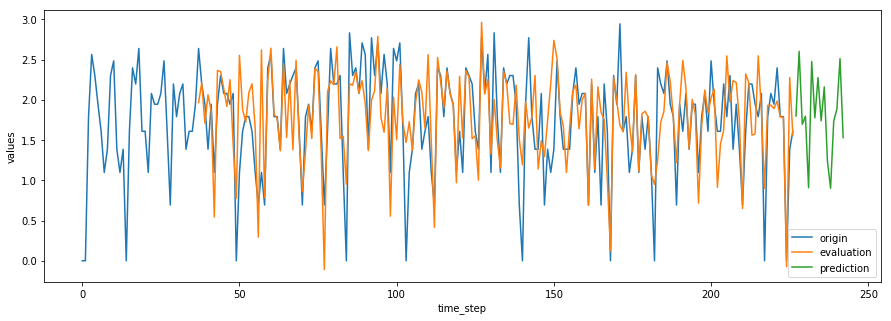

In [17]:
#시각화
plt.figure(figsize=(15, 5))
plt.plot(x.reshape(-1), y.reshape(-1), label='origin')
plt.plot(evaluation['times'].reshape(-1), evaluation['mean'].reshape(-1), label='evaluation')
plt.plot(ar_predictions['times'].reshape(-1), ar_predictions['mean'].reshape(-1), label='prediction')
plt.xlabel('time_step')
plt.ylabel('values')
plt.legend(loc=4)
plt.show()

# Tensorflow Timesereies - LSTM

In [18]:
class _LSTMModel(tfts_model.SequentialTimeSeriesModel):
    """A time series model-building example using an RNNCell."""
    
    def __init__(self, num_units, num_features, dtype=tf.float32):
        """Initialize/configure the model object.
        Note that we do not start graph building here. Rather, this object is a
        configurable factory for TensorFlow graphs which are run by an Estimator.
        Args:
          num_units: The number of units in the model's LSTMCell.
          num_features: The dimensionality of the time series (features per
            timestep).
          dtype: The floating point data type to use.
        """
        
        super(_LSTMModel, self).__init__(
            # Pre-register the metrics we'll be outputting (just a mean here).
            train_output_names=["mean"],
            predict_output_names=["mean"],
            num_features=num_features,
            dtype=dtype)
        self._num_units = num_units
        # Filled in by initialize_graph()
        self._lstm_cell = None
        self._lstm_cell_run = None
        self._predict_from_lstm_output = None

    def initialize_graph(self, input_statistics):
        """Save templates for components, which can then be used repeatedly.
        This method is called every time a new graph is created. It's safe to start
        adding ops to the current default graph here, but the graph should be
        constructed from scratch.
        Args:
          input_statistics: A math_utils.InputStatistics object.
        """
        
        super(_LSTMModel, self).initialize_graph(input_statistics=input_statistics)
        self._lstm_cell = tf.nn.rnn_cell.LSTMCell(num_units=self._num_units)
        # Create templates so we don't have to worry about variable reuse.
        self._lstm_cell_run = tf.make_template(
            name_="lstm_cell",
            func_=self._lstm_cell,
            create_scope_now_=True)
        # Transforms LSTM output into mean predictions.
        self._predict_from_lstm_output = tf.make_template(
            name_="predict_from_lstm_output",
            func_=
            lambda inputs: tf.layers.dense(inputs=inputs, units=self.num_features),
            create_scope_now_=True)

    def get_start_state(self):
        """Return initial state for the time series model."""
        return (
            # Keeps track of the time associated with this state for error checking.
            tf.zeros([], dtype=tf.int64),
            # The previous observation or prediction.
            tf.zeros([self.num_features], dtype=self.dtype),
            # The state of the RNNCell (batch dimension removed since this parent
            # class will broadcast).
            [tf.squeeze(state_element, axis=0)
             for state_element
             in self._lstm_cell.zero_state(batch_size=1, dtype=self.dtype)])

    def _filtering_step(self, current_times, current_values, state, predictions):
        """Update model state based on observations.
        Note that we don't do much here aside from computing a loss. In this case
        it's easier to update the RNN state in _prediction_step, since that covers
        running the RNN both on observations (from this method) and our own
        predictions. This distinction can be important for probabilistic models,
        where repeatedly predicting without filtering should lead to low-confidence
        predictions.
        Args:
          current_times: A [batch size] integer Tensor.
          current_values: A [batch size, self.num_features] floating point Tensor
            with new observations.
          state: The model's state tuple.
          predictions: The output of the previous `_prediction_step`.
        Returns:
          A tuple of new state and a predictions dictionary updated to include a
          loss (note that we could also return other measures of goodness of fit,
          although only "loss" will be optimized).
        """
        state_from_time, prediction, lstm_state = state
        with tf.control_dependencies(
            [tf.assert_equal(current_times, state_from_time)]):
          # Subtract the mean and divide by the variance of the series.  Slightly
          # more efficient if done for a whole window (using the normalize_features
          # argument to SequentialTimeSeriesModel).
          transformed_values = self._scale_data(current_values)
          # Use mean squared error across features for the loss.
          predictions["loss"] = tf.reduce_mean(
              (prediction - transformed_values) ** 2, axis=-1)
          # Keep track of the new observation in model state. It won't be run
          # through the LSTM until the next _imputation_step.
          new_state_tuple = (current_times, transformed_values, lstm_state)
        return (new_state_tuple, predictions)

    def _prediction_step(self, current_times, state):
        """Advance the RNN state using a previous observation or prediction."""
        _, previous_observation_or_prediction, lstm_state = state
        lstm_output, new_lstm_state = self._lstm_cell_run(
            inputs=previous_observation_or_prediction, state=lstm_state)
        next_prediction = self._predict_from_lstm_output(lstm_output)
        new_state_tuple = (current_times, next_prediction, new_lstm_state)
        return new_state_tuple, {"mean": self._scale_back_data(next_prediction)}

    def _imputation_step(self, current_times, state):
        """Advance model state across a gap."""
        # Does not do anything special if we're jumping across a gap. More advanced
        # models, especially probabilistic ones, would want a special case that
        # depends on the gap size.
        return state

    def _exogenous_input_step(
        self, current_times, current_exogenous_regressors, state):
        """Update model state based on exogenous regressors."""
        raise NotImplementedError(
            "Exogenous inputs are not implemented for this example.")

In [19]:
#배치사이즈 16 윈도우 사이즈 21(3주) 16000번 학습
x, y, reader = data_to_npreader(store_nbr=2, item_nbr=105574)

train_input_fn = tf.contrib.timeseries.RandomWindowInputFn(
      reader, batch_size=16, window_size=21)

estimator = tfts_estimators.TimeSeriesRegressor(
      model=_LSTMModel(num_features=1, num_units=32),
      optimizer=tf.train.AdamOptimizer(0.001))

estimator.train(input_fn=train_input_fn, steps=16000)
evaluation_input_fn = tf.contrib.timeseries.WholeDatasetInputFn(reader)
evaluation = estimator.evaluate(input_fn=evaluation_input_fn, steps=1)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_secs': 600, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x117e2e128>, '_model_dir': '/var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmpg8tnmmx4', '_save_checkpoints_steps': None, '_task_type': 'worker', '_task_id': 0, '_service': None, '_is_chief': True, '_log_step_count_steps': 100, '_tf_random_seed': None, '_save_summary_steps': 100, '_session_config': None, '_master': '', '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmpg8tnmmx4/model.ckpt.
INFO:tensorflow:loss = 1.07051, step = 1
INFO:tensorflow:global_step/sec: 61.1634
INFO:tensorflow:loss = 0.838396, step = 101 (1.637 sec)
INFO:tensorflow:global_step/sec: 67.8808
INFO:tensorflow:loss = 0.815506, step 

INFO:tensorflow:loss = 0.235577, step = 7501 (2.605 sec)
INFO:tensorflow:global_step/sec: 48.4422
INFO:tensorflow:loss = 0.316575, step = 7601 (2.067 sec)
INFO:tensorflow:global_step/sec: 41.7768
INFO:tensorflow:loss = 0.233322, step = 7701 (2.390 sec)
INFO:tensorflow:global_step/sec: 46.7126
INFO:tensorflow:loss = 0.228763, step = 7801 (2.142 sec)
INFO:tensorflow:global_step/sec: 55.6286
INFO:tensorflow:loss = 0.234701, step = 7901 (1.798 sec)
INFO:tensorflow:global_step/sec: 55.686
INFO:tensorflow:loss = 0.314971, step = 8001 (1.795 sec)
INFO:tensorflow:global_step/sec: 53.7419
INFO:tensorflow:loss = 0.246718, step = 8101 (1.866 sec)
INFO:tensorflow:global_step/sec: 49.947
INFO:tensorflow:loss = 0.229011, step = 8201 (1.998 sec)
INFO:tensorflow:global_step/sec: 50.2188
INFO:tensorflow:loss = 0.276212, step = 8301 (1.991 sec)
INFO:tensorflow:global_step/sec: 39.5278
INFO:tensorflow:loss = 0.27451, step = 8401 (2.533 sec)
INFO:tensorflow:global_step/sec: 48.1469
INFO:tensorflow:loss = 

INFO:tensorflow:global_step/sec: 53.3874
INFO:tensorflow:loss = 0.191575, step = 15901 (1.874 sec)
INFO:tensorflow:Saving checkpoints for 16000 into /var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmpg8tnmmx4/model.ckpt.
INFO:tensorflow:Loss for final step: 0.173221.
INFO:tensorflow:Starting evaluation at 2017-12-12-04:25:10
INFO:tensorflow:Restoring parameters from /var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmpg8tnmmx4/model.ckpt-16000
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2017-12-12-04:25:11
INFO:tensorflow:Saving dict for global step 16000: global_step = 16000, loss = 0.126306, mean = [[[ 1.96783817]
  [ 1.69192195]
  [ 2.27688265]
  [ 2.02433133]
  [ 1.93697023]
  [ 1.78823042]
  [ 1.75075042]
  [ 1.95224082]
  [-0.00871849]
  [ 1.237679  ]
  [ 2.33975959]
  [ 0.65005732]
  [ 2.01718974]
  [ 2.18769264]
  [ 1.69933963]
  [ 2.16778731]
  [ 2.19370842]
  [ 1.7557162 ]
  [ 1.69371235]
  [ 0.02991891]
  [ 1.40008974]
  [ 1.36535144]
  [ 1.918059

In [20]:
(lstm_predictions,) = tuple(estimator.predict(
      input_fn=tf.contrib.timeseries.predict_continuation_input_fn(
          evaluation, steps=16)))

INFO:tensorflow:Restoring parameters from /var/folders/9f/r85pl3x54ysbtzyrt_jv00y40000gn/T/tmpg8tnmmx4/model.ckpt-16000


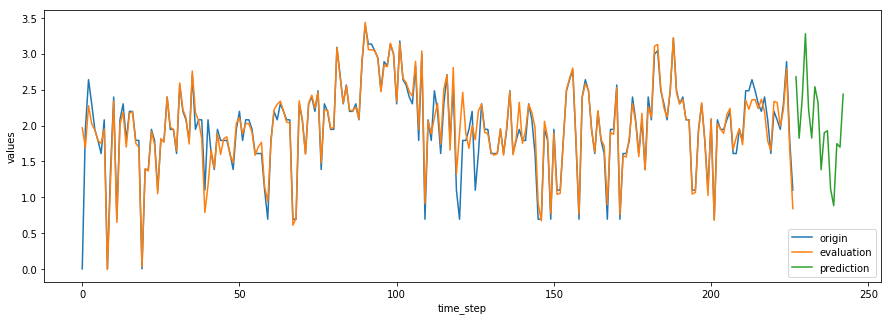

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(x.reshape(-1), y.reshape(-1), label='origin')
plt.plot(evaluation['times'].reshape(-1), evaluation['mean'].reshape(-1), label='evaluation')
plt.plot(lstm_predictions['times'].reshape(-1), lstm_predictions['mean'].reshape(-1), label='prediction')
plt.xlabel('time_step')
plt.ylabel('values')
plt.legend(loc=4)
plt.show()

# Forecasting Test data

In [22]:
# Read test dataset
test = pd.read_csv('../input/test.csv', dtype=dtypes, parse_dates=['date'])
test['dow'] = test['date'].dt.dayofweek

#세가지 방법 합치기()
# Moving Average
test = pd.merge(test, ma_is, how='left', on=['item_nbr','store_nbr'])
test = pd.merge(test, ma_wk, how='left', on=['item_nbr','store_nbr'])
test = pd.merge(test, ma_dw, how='left', on=['item_nbr','store_nbr','dow'])
test['unit_sales'] = test.mais

# Autoregressive
ar_predictions['mean'][ar_predictions['mean'] < 0] = 0
test.loc[np.logical_and(test['store_nbr'] == 1, test['item_nbr'] == 105574), 'unit_sales'] = ar_predictions['mean']

# LSTM
lstm_predictions['mean'][lstm_predictions['mean'] < 0] = 0
test.loc[np.logical_and(test['store_nbr'] == 2, test['item_nbr'] == 105574), 'unit_sales'] = lstm_predictions['mean']

In [23]:
#다른 커널에서 적용한 경험적인 부분
pos_idx = test['mawk'] > 0
test_pos = test.loc[pos_idx]
test.loc[pos_idx, 'unit_sales'] = test_pos['unit_sales'] * test_pos['madw'] / test_pos['mawk']

In [24]:
test.loc[:, "unit_sales"].fillna(0, inplace=True)
#로그 스케일 다시 되돌리는 작업
test['unit_sales'] = test['unit_sales'].apply(pd.np.expm1) # restoring unit values 
test['mais'] = test['mais'].apply(pd.np.expm1) # restoring unit values 

In [25]:
#'연휴때는 얼만큼 더 팔렸다'는 데이터 적용
holiday = pd.read_csv('../input/holidays_events.csv', parse_dates=['date'])
holiday = holiday.loc[holiday['transferred'] == False]

test = pd.merge(test, holiday, how = 'left', on =['date'] )
test['transferred'].fillna(True, inplace=True)

test.loc[test['transferred'] == False, 'unit_sales'] *= 1.2
test.loc[test['onpromotion'] == True, 'unit_sales'] *= 1.5

In [26]:
test.loc[np.logical_and(test['store_nbr'] == 1, test['item_nbr'] == 105574)]

,id,date,store_nbr,item_nbr,onpromotion,dow,mais226,mais112,mais56,mais28,...,mais1,mais,mawk,madw,unit_sales,type,locale,locale_name,description,transferred
5,125497045,2017-08-16,1,105574,False,2,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,2.134940,7.300340,NaN,NaN,NaN,NaN,True
210659,125707699,2017-08-17,1,105574,False,3,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,1.967375,15.804115,NaN,NaN,NaN,NaN,True
421313,125918353,2017-08-18,1,105574,False,4,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,1.966771,5.283558,NaN,NaN,NaN,NaN,True
631967,126129007,2017-08-19,1,105574,False,5,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,1.625417,4.002367,NaN,NaN,NaN,NaN,True
842621,126339661,2017-08-20,1,105574,False,6,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,1.061052,0.700328,NaN,NaN,NaN,NaN,True
1053275,126550315,2017-08-21,1,105574,False,0,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,1.985781,14.028633,NaN,NaN,NaN,NaN,True
1263929,126760969,2017-08-22,1,105574,False,1,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,1.962468,5.836592,NaN,NaN,NaN,NaN,True
1474583,126971623,2017-08-23,1,105574,False,2,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,2.134940,13.570710,NaN,NaN,NaN,NaN,True
1685237,127182277,2017-08-24,1,105574,False,3,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,1.967375,6.712863,Holiday,Local,Ambato,Fundacion de Ambato,False
1895891,127392931,2017-08-25,1,105574,False,4,1.753432,1.721587,1.702692,1.6992,...,1.609438,4.281408,1.814829,1.966771,9.406841,NaN,NaN,NaN,NaN,True


In [27]:
test[['id','unit_sales']].to_csv('submission.csv.gz', index=False, compression='gzip')

- RMSL error : 0.531

### 개선점 
* lstm 
* 연휴나 세일 값 조절